# Exercises on solving systems of linear equation

## Exercise 7.1
Implement a `transformed()` method on the `PolygonModel` that returns the points of the model translated by the object's x and y attributes and rotated by its `rotation_angle` attribute.

The translation part was already applied in the model:

```python
class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

    # added in section 7.1.2
    def transformed(self):
        return [add((self.x, self.y), v) for v in self.points] 
```

So the only remaining part is to apply the rotation, before the translation.

As we've done while developing the game, we differentiate two contexts:
+ The *Math model* in which the shapes are collections of points that delimit polygons on a traditional coordinate plane that goes from -10 to 10 on each axis, and where we can apply our vector library.
+ The *game engine* that is used to render the game components on a 400x400 window.

Both *contexts* are linked through the `to_pixels(...)` function that takes the *Math model* and translates the points and polygons into something that can be fed into *PyGame* functions.

As a consequence, the rotation should be defined at the *Math model* level, and then we should leave the `to_pixels(...)` function do the rest.

Let's recall what was needed to rotate a vector:


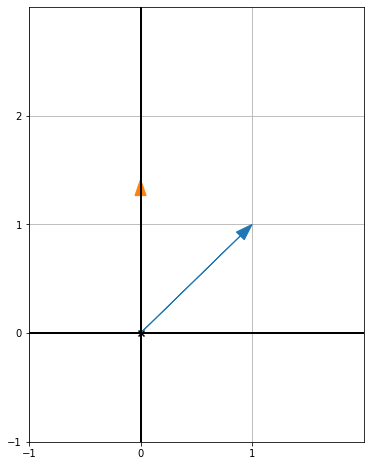

In [7]:
from my_colors import blue, orange
from my_draw2d import draw2d, Arrow2D
from math import pi, sin, cos
from my_vectors import to_polar, to_cartesian

orig_v = (1, 1)
orig_v_polar = to_polar(orig_v)
d, theta = orig_v_polar
theta = theta + pi / 4

rotated_v = to_cartesian((d, theta))

draw2d(Arrow2D(orig_v, color=blue), Arrow2D(rotated_v, color=orange))

In that chapter we even defined a function `rotate2d(...)` so that we don't have to repeat the steps again.

As a result, the `transformed` function will end up being:

In [ ]:
from my_vectors import add, rotate2d
from random import randint, uniform        

class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

    def transformed(self):
        rotated_points = [rotate2d(self.rotation_angle, point) for point in self.points]
        return [add((self.x, self.y), rotated_point) for rotated_point in rotated_points]        


Let's check it works with the `Ship`, and on the *Math model* first:

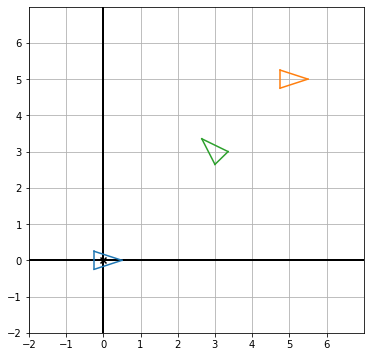

In [12]:
from my_game import Ship
from my_draw2d import draw2d, Polygon2D
from my_colors import blue, orange, green
from math import pi



# blue: not transformed
# orange: translation only
# green: translation and rotation

blue_ship = Ship()

orange_ship = Ship()
orange_ship.x = 5
orange_ship.y = 5

green_ship = Ship()
green_ship.x = 3
green_ship.y = 3
green_ship.rotation_angle = 3 * pi / 4


draw2d(
    Polygon2D(*blue_ship.points, color = blue),
    Polygon2D(*orange_ship.transformed(), color=orange),
    Polygon2D(*green_ship.transformed(), color=green)    
    )



Now, we just need to test it in the game engine to see it also works.

We'll start by making the ship to rotate 360° every 5 seconds.

(this is the [Step 3](../e01-exercises/asteroids_step3.py))

In [1]:
from asteroids_step3 import main

main()

pygame 2.0.0 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 0

## Exercise 7.2

Implement yourself the function `to_pixels(x, y)` that takes a pair of x-y coordinates in the square where $ -10 < x < 10 $ and $ -10 < y < 10 $ and maps them to the PyGame engine pixel coordinates which ranges from 0 to 400 with the $ (0, 0) $ placed in the top left corner, x increasing to the right and y increasing to the bottom.

We already used this function in the `my-game` library. In the exercise, we will explain the rationale.

In the *Math model* for our game we have different objects that are drawn in the traditional x-y coordinates that range from -10 to 10. We know that the display for our game is a 400x400 screen, with the top-left corner being the origin `(0,0)` and the bottom-right corner the `(400, 400)` point.

Therefore, we need to *translate* the coordinates:
$
(-10, 10) \Rightarrow (0, 0) \\
(-10, -10) \Rightarrow (0, 400) \\
(10, 10) \Rightarrow (400, 0) \\
(10, -10) \Rightarrow (400, 400) \\
$


We need to find a couple of linear functions that map those coordinate systems.

One way to do it is with a couple of systems of linear equations for the x and y transformations:

x transformation:

$
a \cdot (-10) + b = 0 \\
a \cdot 10 + b = 400 \\
$

which gives us $ f(x) = 20 \cdot x + 200 $

y transformation:

$
a \cdot 10 + b = 0 \\
a \cdot (-10) + b = 400 \\
$

which gives us $ g(x) = -20 \cdot x + 200 $


In [5]:
def to_pixels(x, y):
    return (20 * x + 200, -20 * y + 200)

print(to_pixels(-10, 10))   # should be (0, 0)
print(to_pixels(-10, -10))  # should be (0, 400)
print(to_pixels(10, 10))    # should be (400, 0)
print(to_pixels(10, -10))   # should be (400, 400)
print(to_pixels(0, 0))      # should be (200, 200)

(0, 0)
(0, 400)
(400, 0)
(400, 400)
(200, 200)


Now that we have the approach in place, we can try to generalize it for other lengths of the *Math* and *game engine* model, so that we can create a function that *generates* `to_pixel()` functions.

Math model:
$
 x_{min} <= x <= x_{max} \\
 y_{min} <= y <= y_{max}
$

Game engine:
$
 0 <= x <= width \\
 0 <= y <= height
$


+ Let $ f(x) $ be the function that maps x coordinates from the *Math* to the *game* model
+ Let $ g(y) $ be the function that maps y coordinates from the *Math* to the *game* model

$
f(x_{min}) = 0 = a x_{min} + b \\
f(x_{max}) = width = a x_{max} + b\\
$

which gives us:

$
f(x) = \frac{width}{x_{max} - x_{min}} \cdot x - \frac{x_{min} \cdot width}{x_{max} - x_{min}}
$


Similarly for g:

$
g(y_{min}) = height = a y_{min} + b \\
g(y_{max}) = width = a y_{max} + b\\
$

which gives us:

$
g(y) = \frac{height}{y_{min} - y_{max}} \cdot y - \frac{y_{max} \cdot height}{y_{min} - y_{max}}
$

See how those two functions give us the expected functions when the widht and height of the game engine window is 400x400 and the Math model goes from -10 to 10 in both x and y coordinates.

Now we can define the factory function for the generic `to_pixel(...)` function.

In [5]:
def to_pixels_factory(x_min, x_max, y_min, y_max, width, height):
    x_size = x_max - x_min
    y_size = y_max - y_min
    def new_to_pixels_function(x, y):
        x_game = (width / x_size) * x - (x_min * width / x_size)
        y_game = -(height / y_size) * y + (y_max * height / y_size)
        return (x_game, y_game)
    return new_to_pixels_function

to_pixels = to_pixels_factory(-10, 10, -10, 10, 400, 400)

print(to_pixels(-10, 10))   # should be (0, 0)
print(to_pixels(-10, -10))  # should be (0, 400)
print(to_pixels(10, 10))    # should be (400, 0)
print(to_pixels(10, -10))   # should be (400, 400)
print(to_pixels(0, 0))      # should be (200, 200)
print('==================')

to_pixels = to_pixels_factory(-100, 100, -100, 100, 1024, 768)

print(to_pixels(-100, 100))   # should be (0, 0)
print(to_pixels(-100, -100))  # should be (0, 768)
print(to_pixels(100, 100))    # should be (1024, 0)
print(to_pixels(100, -100))   # should be (1024, 768)
print(to_pixels(0, 0))      # should be (512, 384)


(0.0, 0.0)
(0.0, 400.0)
(400.0, 0.0)
(400.0, 400.0)
(200.0, 200.0)
(0.0, 0.0)
(0.0, 768.0)
(1024.0, 0.0)
(1024.0, 768.0)
(512.0, 384.0)


## Exercises 7.3

It's possible that $ u + t \cdot v $ can be a line through the origin. In this case, what can you say about the vectors $ u $ and $ v $?.

We know that the formula $ u + t \cdot v $ gives us every possible line of the 2D plane.

We also know that the lines $ t \cdot v $ always pass through the origin, for $ t = 0 $.

But also:

$ 
u + t \cdot v = 0 \\
u = -t \cdot v \text{  , for t } \in \mathbb{R}
$

Therefore, $ u $ and $ v $ are scalar multiples.


## Exercise 7.4

If $ v = (0, 0) = \vec{0} $, do points of the form $ u + t \cdot v $ represent a line?

If we use cartesian coordinates:

$
r(t) = u = (x_1, y_1)
$

Therefore, indepedently of the value of t, we would get $ u $ and therefore, not a line.

## Exercise 7.5

It turns out that the formula $ u + t \cdot v $ to represent a line is not unique. That is, you can pick different values of $ u $ and $ v $ to represent the same line. What is another line representing $ (2, 2) + t \cdot (-1, 3) $?

One solution is to replace $ v = (-1, 3) $ by an scalar multiple, because we will always find other $ t $ satisfying the same values.

Therefore, $ (2, 2) + t \cdot (-2, 6) $ is another formula.

Another, not so obvious solution is to replace $ u $ by any other point of the line.

For example, for $ t = 1 $, we get the point $ (1, 5) $. Therefore, $ (1, 5) + t \cdot (-1, 3) $ is also a valid equation for the same line.

Therefore we can find different equations in the form $ u + t \cdot v $ for the same line just by:
+ replacing $ u $ by any point along the line
+ replacing $ v $ by an scalar multiple

## Exercise 7.6

Does the formula $ a \cdot x + b \cdot y = c $ represent a line for any values of $ a $, $ b $ and $ c $.

No, if $ a = 0 $ and $ b = 0 $, the formula ends up being:

$
c = 0
$

which does not describe any relationship between $ x $ and $ y $ and therefore does not describe a line.

## Exercise 7.7

Find another equation for the $ 2x + y = 3 $, showing that the choices of $ a $, $ b $ and $ c $ are not unique.

Multiplying both sides of the equation by the same number gives us another equation that satisfies the same points:

$
4x + 2y = 6 \\
6x + 3y = 9 \\
...
$

## Exercise 7.8

The equation $ ax + by = c $ is equivalent to an equation involving a dot product of two 2D vectors:

$
(a, b) \cdot (x, y) = c
$

You could therefore say that a line is a set of vectors whose dot procut with a given vector is a constant. What is the geometric representation of this statement?

From the [chapter 02](../../02-the-3d-space) we know that the dot product of two vectors is a measurement of how two vectors are aligned.

Therefore, if $ u = (a, b) $, $ v = (x, y) $ and $ u \cdot v = c $, with $ c $ being constant, means finding all possible vectors which are equally aligned with $ u $.

Let's see this with an example of a given line: $ 2x + y = 8 $. This can be written as the dot product of $ (2, 1) \cdot (x, y) = 8 $. That is, the line is the collection of vectors that are equally aligned with $ (2, 1) $ so that the dot product is 8.


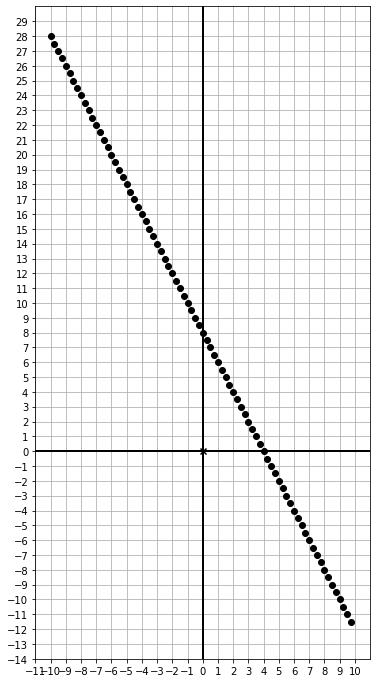

In [2]:
import numpy as np
from my_draw2d import draw2d, Points2D 

# points in the line
def f(x):
    return 8 - 2 * x

points = [(x, f(x)) for x in np.arange(-10, 10, 0.25)]

draw2d(Points2D(*points))

Let's take a couple of points from the line, for example the ones for which $ x = 0 $ and $ y = 0 $.

$
2x + y = 8 \Rightarrow p_1 = (0, 8), \hspace{1 ex} p_2=(4, 0)
$

Let's calculate how those 2 vectors are aligned with $ (2, 1) $.


In [10]:
from my_vectors import to_polar, to_degrees, dot

u = (2, 1)
_, u_theta_rad = to_polar(u)
u_theta = to_degrees(u_theta_rad)

p_1 = (0, 8)
_, p1_theta_rad = to_polar(p_1)
p1_theta = to_degrees(p1_theta_rad)

p_2 = (4, 0)
_, p2_theta_rad = to_polar(p_2)
p2_theta = to_degrees(p2_theta_rad)

print('u_theta={}'.format(u_theta))
print('p1_theta={}'.format(p1_theta))
print('p2_theta={}'.format(p2_theta))

print(dot(u, p_1))
print(dot(u, p_2))


u_theta=26.56505117707799
p1_theta=90.0
p2_theta=0.0
8
8


Nothing conclusive... probably later.

## Exercise 7.9

Confirm that the vectors $ (0, 7) $ and $ (3.5, 0) $ both satisfy the equation $ 2x + y = 7 $.

It's obvious that:

$
2 \cdot 0 + 7 = 7 \\
2 \cdot 3.5 + 0 = 7
$

## Exercise 7.10

Draw a graph for (3, 0) + t \cdot (0, 1) and convert it to the standard form using the formula from the concepts section.

The parametric formula: $ (3, 0) + t \cdot (0, 1) $ gives us:

$
(3, 0) + t \cdot (0, 1) = (x, y) \\
\begin{cases}
x = 3 \\
y = t
\end{cases}
$

Therefore, it describes the vertical line with all the points in the 2d plane with $ x = 3 $.

We can find the *standard form* for that parametric line using the formula:

$
(y_2 - y_1) \cdot x + (x_1 - x_2) \cdot y = x_1 (y_2 - y_1) + (x_1 - x_2) y_1
$

with $ (x_1, y_1) $ and $ (x_2, y_2) $ being two points in the line described by the parametric formula of the line, for example $ (3, 0) $ and $ (3, 1) $.

$
(x_1, y_1) = (3, 0) \\
(x_2, y_2) = (3, 1) \\
$

$
x + 0 \cdot y = 3 \cdot 1 + 0
$

Therefore, the *standard form* for the line described by $ (3, 0) + t \cdot (0, 1) $ is $ x = 3 $.

In [ ]:
We can draw it using Python:

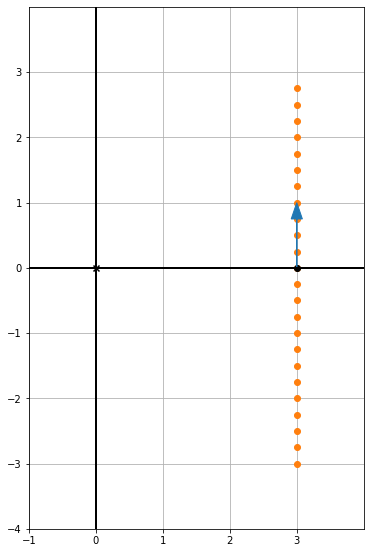

In [18]:
from my_draw2d import draw2d, Arrow2D, Points2D
from my_colors import blue, orange, black
from my_vectors import add, scale
import numpy as np

parametric_points = [add((3, 0), scale(t, (0, 1))) for t in np.arange(-3, 3, 0.25)]

draw2d(
    Points2D(*parametric_points, color=orange),
    Points2D((3, 0), color=black),
    Arrow2D(add((0, 1), (3, 0)), (3, 0), color=blue)
)

That diagram is interesting, because it shows that the parametric formula $ u + t \cdot v $ is just a set of points that result from adding $ u $ and the scalar multiples of $ v $.

## Exercise 7.11

Write a Python function `standard_form(...)` that takes two vectors `v1` and `v2` and finds the line $ ax + by = c $ passing through both of them. The result of the function should be the tuple of constants `(a, b, c)`.

As we already know the formula that given two points returns the *standard form* for the line that passes those two points, it will be very easy:

Let $ (x_1, y_1) $ and $ (x_2, y_2) $ two points defining a line in the 2D plane:

$
(y_2 - y_1) \cdot x + (x_1 - x_2) \cdot y = x_1 y_2  - y_1 x_2
$

In [19]:
def standard_form(v1, v2):
    x1, y1 = v1
    x2, y2 = v2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - y1 * x2
    return (a, b, c)


v1 = (1, 1)
v2 = (2, 2)

print(standard_form(v1, v2))

(1, -1, 0)


## Exercise 7.12

For each of the four distance checks in `do_segments_intersect(...)` find a pair of line segments that fail one of the checks but pass the other three checks.

Let's create a library first with all the colision detection code we saw in the concepts section. That will serve as a summary and will help us solve the exercise.

We first saw the parametric formula for a line was:

$
r(t) = u + v \cdot t
$

We concluded that the formula is much more flexible than the classic $ y = m \cdot x + n $, because you cannot represent vertical lines with the latter.

Then we saw, that we can get the vectors $ u $ and $ v $ for the parametric formula from two points that are part of the line:

$
\text{Let } p_1 = (x_1, y_1) \text{ and } p_2 = (x_2, y_2) \\
r(t) = p_1 + t \cdot (p_2 - p_1)
$

Let's validate how the parametric formula works, and how we can use it to draw lines in 2D:

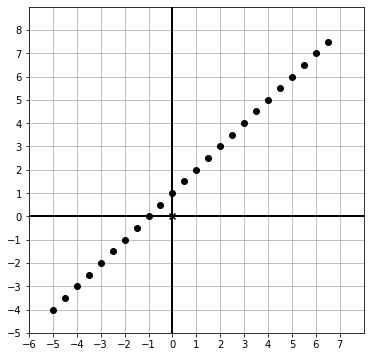

In [1]:
from my_linear_equations import parametric_form_fn
from my_draw2d import draw2d, Points2D
import numpy as np

p1 = (1, 2)
p2 = (3, 4)

parametric_fn = parametric_form_fn(p1, p2)

points = [parametric_fn(t) for t in np.arange(-3, 3, 0.25)]

draw2d(Points2D(*points))

We also saw that the parametric formula has the drawback of the $ t $ parameter, and concluded that the *standard form* $ ax + by = c $ was a better fit as it does not include any extra parameter and let us draw any kind of line.

Let's use that standard form to draw the same line:

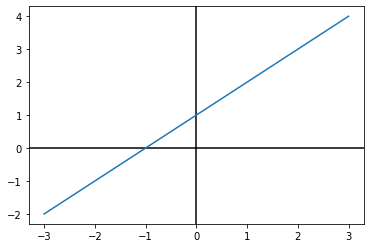

In [5]:
from my_linear_equations import standard_form_fn
from my_plot import plot

p1 = (1, 2)
p2 = (3, 4)

standard_fn = standard_form_fn(p1, p2)

plot([standard_form_fn(p1, p2)], -3, 3)



Then we started the discussion of about how to find if there was a collision between the beam and the asteroid by finding the intersection between two segments.

Firstly, we noticed that finding the intersection between two lines defined by their standard form as $ a_1 x + b_1 y = c_1 $ and $ a_2 x + b_2 y = c_2 $ was the same as finding the solution to the following equations:

$
a_1 x + b_1 y = c_1 \\
a_2 x + b_2 y = c_2 \\
$

which can be written as a matrix multiplication as:

$
\begin{pmatrix}
a_1 & b_1 \\
a_2 & b_2 
\end{pmatrix} \begin{pmatrix}
x \\
y
\end{pmatrix} = \begin{pmatrix}
c_1 \\
c_2
\end{pmatrix}
$

The matrix representation of the system of linear equations was useful *only* because the *NumPy* library includes a function that gives us the solution to those system by passing the matrices:

$
A = \begin{pmatrix}
a_1 & b_1 \\
a_2 & b_2
\end{pmatrix} \\
C = \begin{pmatrix}
c_1 \\
c_2
\end{pmatrix}
$

Let's see it in action for the lines that go through $ (2, 2) $ and $ (4, 4) $, and the line that goes through $ (0, 4) $ and $ (0, 8) $, first visually, then using *NumPy*

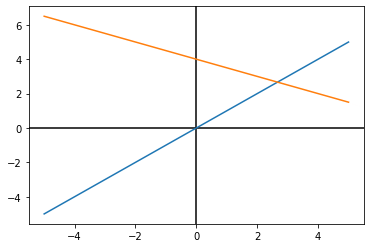

intersection_point=[2.66666667 2.66666667]


In [8]:
from my_linear_equations import standard_form_fn, standard_form
from my_plot import plot
import numpy as np

p1_1 = (2, 2)
p1_2 = (4, 4)

p2_1 = (0, 4)
p2_2 = (8, 0)

plot([standard_form_fn(p1_1, p1_2), standard_form_fn(p2_1, p2_2)], -5, 5)

a1, b1, c1 = standard_form(p1_1, p1_2)
a2, b2, c2 = standard_form(p2_1, p2_2)

a = (
    (a1, b1),
    (a2, b2)
)

c = (c1, c2)

intersection_point = np.linalg.solve(np.array(a), np.array(c))
print('intersection_point={}'.format(intersection_point))



That simple set of actions can be described actions a Python function that takes the 4 points used above:

In [1]:
from my_linear_equations import intersection

p1_1 = (2, 2)
p1_2 = (4, 4)

p2_1 = (0, 4)
p2_2 = (8, 0)

print(intersection(p1_1, p1_2, p2_1, p2_2))

[2.66666667 2.66666667]


While that gives us the intersection (or solution) of the system of linear equations it won't help detect if two segments intersect, as the segments have a definite length.